# DAY 37 · GPU训练与 __call__ 方法

- 重新跑通鸢尾花分类任务并记录 CPU 运行时长
- 学习如何快速了解硬件配置，尤其是 CPU 与 GPU
- 掌握在 PyTorch 中将数据和模型迁移到 GPU 的常见做法
- 分析 GPU 看起来更慢的根源并给出优化策略
- 理解 nn.Module 中 __call__ 的工作机制


## 1. 在 CPU 上搭建基线

先用 CPU 完成一次完整训练流程，包含数据预处理、模型定义、训练循环和耗时统计。

Epoch [100/20000], Loss: 1.0882
Epoch [200/20000], Loss: 1.0701
Epoch [300/20000], Loss: 1.0455
Epoch [400/20000], Loss: 1.0111
Epoch [500/20000], Loss: 0.9649
Epoch [600/20000], Loss: 0.9090
Epoch [700/20000], Loss: 0.8466
Epoch [800/20000], Loss: 0.7813
Epoch [900/20000], Loss: 0.7184
Epoch [1000/20000], Loss: 0.6617
Epoch [1100/20000], Loss: 0.6130
Epoch [1200/20000], Loss: 0.5721
Epoch [1300/20000], Loss: 0.5380
Epoch [1400/20000], Loss: 0.5092
Epoch [1500/20000], Loss: 0.4845
Epoch [1600/20000], Loss: 0.4630
Epoch [1700/20000], Loss: 0.4439
Epoch [1800/20000], Loss: 0.4265
Epoch [1900/20000], Loss: 0.4107
Epoch [2000/20000], Loss: 0.3959
Epoch [2100/20000], Loss: 0.3821
Epoch [2200/20000], Loss: 0.3691
Epoch [2300/20000], Loss: 0.3568
Epoch [2400/20000], Loss: 0.3451
Epoch [2500/20000], Loss: 0.3339
Epoch [2600/20000], Loss: 0.3233
Epoch [2700/20000], Loss: 0.3131
Epoch [2800/20000], Loss: 0.3033
Epoch [2900/20000], Loss: 0.2940
Epoch [3000/20000], Loss: 0.2851
Epoch [3100/20000],

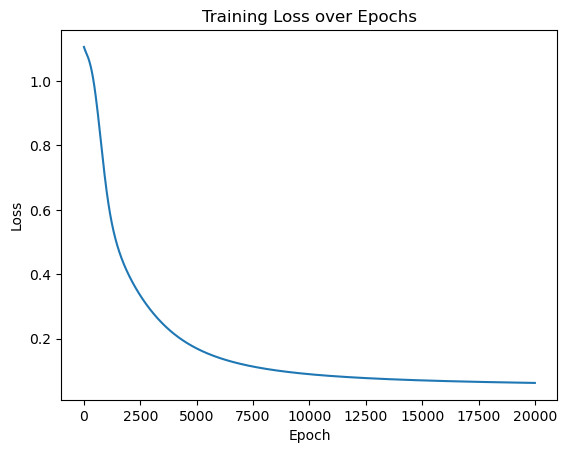

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

# 仍然用4特征，3分类的鸢尾花数据集作为我们今天的数据集
# 加载鸢尾花数据集
iris = load_iris()
X = iris.data  # 特征数据
y = iris.target  # 标签数据
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化数据，神经网络对于输入数据的尺寸敏感，归一化是最常见的处理方式
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) #确保训练集和测试集是相同的缩放

# 将数据转换为 PyTorch 张量
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 20000
losses = []

import time
start_time = time.time()

for epoch in range(num_epochs):
    outputs = model.forward(X_train)   # 显式调用forward函数
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

time_all = time.time() - start_time
print(f'Training time: {time_all:.2f} seconds')

import matplotlib.pyplot as plt
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()


### 1.1 查看 CPU 指标

上述是在cpu的情况下训练，（即使安装了cuda，但是没有使用cuda），我们借这个机会简单介绍下cpu的性能差异。


我使用的是wsl。因此我在终端输入lscpu来查看CPU信息。
```bash
(base) ubuntu24@DESKTOP-3Q94GS2:~/code/PythonPractice/day_37$ lscpu
CPU(s):                   24
Thread(s) per core:       2
Core(s) per socket:       12
Socket(s):                1
```
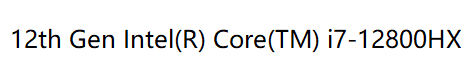
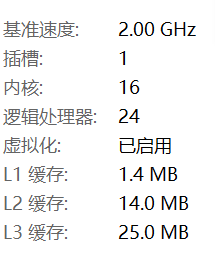



**CPU 配置解读（i7-12800HX）**

* Intel 第 12 代酷睿（Alder Lake）移动端高性能处理器
* 核心架构：混合大小核设计

  * 性能核（P-Core）：8 核，支持超线程（16 线程）
  * 能效核（E-Core）：4 核，不支持超线程
* 物理核心数：12 核
* 逻辑线程数：24




在该配置下，CPU 上的鸢尾花训练平均约 4.6 秒。接下来开始研究 GPU：如何迁移模型、如何评估显卡、又该如何正确理解速度差异。


## 2. GPU 训练

在 PyTorch 中，`.to(device)` 可以把张量或模型移动到指定设备（CPU/GPU）。只有 `torch.Tensor` 对象和继承 `nn.Module` 的模型拥有该方法。实践中需要保证输入张量和模型在同一设备上，否则会抛出运行时错误。


### 2.1 如何快速看懂 GPU 型号

以 RTX 3090 Ti、RTX 3080、RTX 3070 Ti、RTX 4070 等为例：

- **代际**：前两位数字代表代数，40xx 为第 40 代、30xx 为第 30 代。新架构通常意味着更先进的制程和更高的能效比。
- **级别**：后两位数字代表定位。
    - xx90：旗舰/次旗舰，性能最强、显存最大。
    - xx80：高端，性能强劲、显存较多。
    - xx70：中高端，适合兼顾训练和日常使用。


In [3]:
import torch

# 检查CUDA是否可用
if torch.cuda.is_available():
    print("CUDA可用！")
    device_count = torch.cuda.device_count()
    print(f"可用的CUDA设备数量: {device_count}")
    current_device = torch.cuda.current_device()
    print(f"当前使用的CUDA设备索引: {current_device}")
    device_name = torch.cuda.get_device_name(current_device)
    print(f"当前CUDA设备的名称: {device_name}")
    cuda_version = torch.version.cuda
    print(f"CUDA版本: {cuda_version}")
    print("cuDNN版本:", torch.backends.cudnn.version())
else:
    print("CUDA不可用。")


CUDA可用！
可用的CUDA设备数量: 1
当前使用的CUDA设备索引: 0
当前CUDA设备的名称: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA版本: 12.4
cuDNN版本: 90100


In [4]:
# 设置GPU设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")


使用设备: cuda:0


In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 加载鸢尾花数据集
iris = load_iris()
X = iris.data
y = iris.target

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化数据
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 将数据转换为PyTorch张量并移至GPU
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)


In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 实例化模型并移至GPU
model = MLP().to(device)


Epoch [100/20000], Loss: 1.0390
Epoch [200/20000], Loss: 0.9741
Epoch [300/20000], Loss: 0.9003
Epoch [400/20000], Loss: 0.8244
Epoch [500/20000], Loss: 0.7507
Epoch [600/20000], Loss: 0.6835
Epoch [700/20000], Loss: 0.6255
Epoch [800/20000], Loss: 0.5776
Epoch [900/20000], Loss: 0.5386
Epoch [1000/20000], Loss: 0.5066
Epoch [1100/20000], Loss: 0.4798
Epoch [1200/20000], Loss: 0.4570
Epoch [1300/20000], Loss: 0.4372
Epoch [1400/20000], Loss: 0.4197
Epoch [1500/20000], Loss: 0.4039
Epoch [1600/20000], Loss: 0.3894
Epoch [1700/20000], Loss: 0.3760
Epoch [1800/20000], Loss: 0.3635
Epoch [1900/20000], Loss: 0.3517
Epoch [2000/20000], Loss: 0.3405
Epoch [2100/20000], Loss: 0.3298
Epoch [2200/20000], Loss: 0.3196
Epoch [2300/20000], Loss: 0.3099
Epoch [2400/20000], Loss: 0.3006
Epoch [2500/20000], Loss: 0.2917
Epoch [2600/20000], Loss: 0.2831
Epoch [2700/20000], Loss: 0.2749
Epoch [2800/20000], Loss: 0.2671
Epoch [2900/20000], Loss: 0.2596
Epoch [3000/20000], Loss: 0.2524
Epoch [3100/20000],

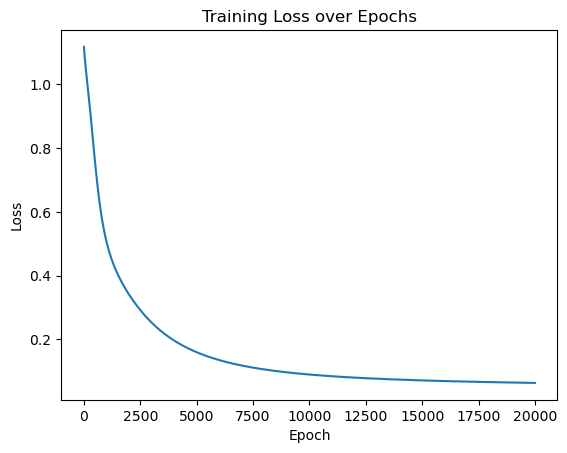

In [7]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20000
losses = []

start_time = time.time()

for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

time_all = time.time() - start_time
print(f'Training time: {time_all:.2f} seconds')

plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()


## 3. 为什么 GPU 表现得更慢？

对于如此小的数据集和简单模型，GPU 往往比 CPU 慢，主要受三类固定开销影响：

1. **数据传输**：CPU 内存与 GPU 显存之间来回拷贝。
2. **核心（kernel）启动**：每个算子都要在 GPU 上启动一次核心程序。
3. **计算资源浪费**：批量小、计算量少，GPU 的并行能力发挥不出来。


### 3.1 数据传输细节

- 在 GPU 计算之前，输入张量、标签与模型参数都要从 RAM 复制到显存。
- `loss.item()` 每次都会把标量从 GPU 拷回 CPU，用于日志打印或可视化。
- 在 20000 个 epoch 的循环中，这些同步操作的总时间并不比实际计算少。


### 3.2 核心启动与批处理

- 每个前向或反向算子都会触发一次 kernel 启动，哪怕只是一个线性层。
- 当只有少量样本和极小的 batch 时，GPU 无法并行足够多的计算来摊平这些固定成本。
- 因此才会看到 “CPU 4.6 秒就跑完，而 GPU 却耗时 17 秒” 的现象。


### 3.3 何时使用 GPU

- 深度学习项目往往动辄几十分钟或数小时，此时 GPU 的高吞吐量能极大缩短训练时间。
- CPU 适合小任务，省去了数据跨芯片的传输。
- GPU 需要把数据、模型搬到显存，且频繁的 kernel 启动会放大额外成本。
- 当模型规模、数据集或 batch size 足够大时，GPU 才能发挥并行优势。


## 4. 减少额外开销的实践

针对上述瓶颈，最直接的方向是减少不必要的 CPU⇄GPU 往返。下面演示两个思路：

1. **彻底停止频繁记录**：不在循环中保存/打印 `loss.item()`，从根源上避免同步。
2. **降低记录频率**：例如改为每 200 个 epoch 才把损失值搬回来。既保留监控指标，也控制传输次数。


In [8]:
# 思路1：完全不记录loss，纯粹观察终端输出
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 20000

start_time = time.time()

for epoch in range(num_epochs):
    outputs = model.forward(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print(f'Training time: {time.time() - start_time:.2f} seconds')


Epoch [100/20000], Loss: 1.0762
Epoch [200/20000], Loss: 1.0561
Epoch [300/20000], Loss: 1.0299
Epoch [400/20000], Loss: 0.9972
Epoch [500/20000], Loss: 0.9581
Epoch [600/20000], Loss: 0.9127
Epoch [700/20000], Loss: 0.8619
Epoch [800/20000], Loss: 0.8082
Epoch [900/20000], Loss: 0.7560
Epoch [1000/20000], Loss: 0.7061
Epoch [1100/20000], Loss: 0.6604
Epoch [1200/20000], Loss: 0.6188
Epoch [1300/20000], Loss: 0.5814
Epoch [1400/20000], Loss: 0.5478
Epoch [1500/20000], Loss: 0.5178
Epoch [1600/20000], Loss: 0.4908
Epoch [1700/20000], Loss: 0.4664
Epoch [1800/20000], Loss: 0.4443
Epoch [1900/20000], Loss: 0.4242
Epoch [2000/20000], Loss: 0.4061
Epoch [2100/20000], Loss: 0.3894
Epoch [2200/20000], Loss: 0.3740
Epoch [2300/20000], Loss: 0.3595
Epoch [2400/20000], Loss: 0.3459
Epoch [2500/20000], Loss: 0.3332
Epoch [2600/20000], Loss: 0.3211
Epoch [2700/20000], Loss: 0.3097
Epoch [2800/20000], Loss: 0.2988
Epoch [2900/20000], Loss: 0.2885
Epoch [3000/20000], Loss: 0.2787
Epoch [3100/20000],

实测下来，GPU 训练时间迅速下降到与 CPU 接近，说明大量时间确实耗在把标量搬回 CPU 上。


使用设备: cuda:0
Epoch [2000/20000], Loss: 0.3663
Epoch [4000/20000], Loss: 0.2058
Epoch [6000/20000], Loss: 0.1371
Epoch [8000/20000], Loss: 0.1054
Epoch [10000/20000], Loss: 0.0886
Epoch [12000/20000], Loss: 0.0787
Epoch [14000/20000], Loss: 0.0723
Epoch [16000/20000], Loss: 0.0679
Epoch [18000/20000], Loss: 0.0646
Epoch [20000/20000], Loss: 0.0622
Training time: 13.08 seconds


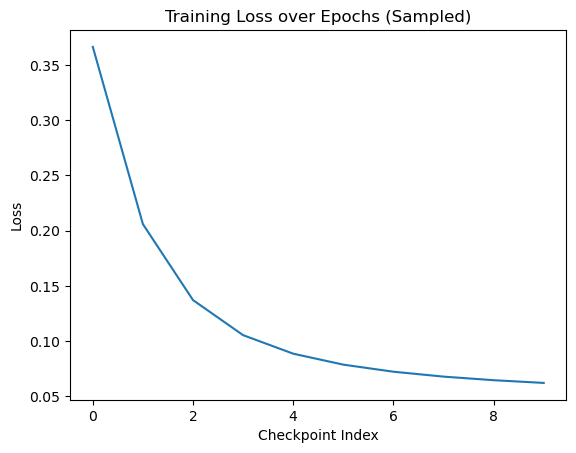

In [13]:
# 思路2：降低记录频率，兼顾可视化与性能
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 20000
losses = []

start_time = time.time()

for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 2000 == 0:
        losses.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


print(f'Training time: {time.time() - start_time:.2f} seconds')

plt.plot(range(len(losses)), losses)
plt.xlabel('Checkpoint Index')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Sampled)')
plt.show()


### 4.1 记录频率与耗时的关系

以总 epoch=20000 为例，我在本地的测试如下，剩余时长=总时长−4.6s（纯计算时间）：

| 记录间隔（轮） | 记录次数（次） | 剩余时长（秒） |
|----------------|----------------|----------------|
| 100            | 200            | 10             |
| 200            | 100            | 9.35           |
| 1000           | 20             | 11.55          |
| 2000           | 10             | 8.5            |

可以看到记录次数越少，额外耗时会略有下降，但并非严格线性；真实项目中应结合监控需求取舍。


## 5. 认识 __call__ 方法

`nn.Linear`、`nn.Module` 的实例之所以可以被写成 `self.fc1(x)`，是因为它们实现了 `__call__`。在 Python 里，任何定义了 `__call__` 的对象都可以像函数一样被调用。


In [14]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


在 `__init__` 中执行 `self.fc1 = nn.Linear(4, 10)` 时，`self.fc1` 变成了一个 `nn.Linear` 的实例。调用 `self.fc1(x)` 实际上会触发 `nn.Module.__call__`，该方法再去调用子类的 `forward`，从而完成前向传播。


### 5.1 无参数示例

`__call__` 可以在每次“函数式调用”时维护内部状态，非常适合封装可调用对象。


In [15]:
class Counter:
    def __init__(self):
        self.count = 0

    def __call__(self):
        self.count += 1
        return self.count

counter = Counter()
print(counter())  # 输出: 1
print(counter())  # 输出: 2
print(counter.count)  # 输出: 2


1
2
2


实例化只会发生一次（`counter = Counter()`），随后每次调用 `counter()` 都会触发 `__call__` 并更新内部的 `count`。


### 5.2 带参数示例

`__call__` 也能像普通函数一样接收参数；对象既能保存状态又能提供行为，非常适合需要“带记忆”的可调用单元。


In [16]:
class Adder:
    def __call__(self, a, b):
        print("唱跳篮球rap")
        return a + b

adder = Adder()
print(adder(3, 5))  # 输出: 8


唱跳篮球rap
8
